# Лабораторная №5

Используя явную и неявную конечно-разностные схемы, а также схему Кранка - Николсона, решить начально-краевую задачу для дифференциального уравнения параболического типа. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $u(x,t) $. Исследовать зависимость погрешности от сеточных параметров $\tau$ и $h$.

### Вариант №5
**_Уравнение:_**
$$
\frac{\partial u}{\partial t} = \frac{\partial ^ 2 u}{\partial x^2} + g(x), \\
$$
где $ g(x) = sin(\pi x) $

**_Граничные условия:_**
$$
\left\{
    \begin{array}\\
        u(0,t)=0\\
        u(\pi,t)=0 \\
        u(x,0)=0
    \end{array}
\right.
$$

**_Аналитическое решение:_**
$$u(x,t)=\frac{1}{\pi ^2}(1-exp(-\pi ^2t))sin(\pi x)$$


## Решение
**Импорты:**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 10]

**Параметры:**

In [2]:
a = 1
T = 1
l = 1
N = 10
sigma = 0.2
h = 1 / N
tau = sigma * h**2 / a
K = int(round(T / tau))
X = np.arange(0, l + h, h)

**Граничные условия и аналитическое решение**

In [3]:
def u_0_t(t):
    return 0
def u_l_t(t):
    return 0
def u_x_0(t):
    return 0
def g(x):
    return np.sin(np.pi * x)
def analytic_solution(x, t):
    return (1 / (np.pi ** 2)) * (1 - np.exp(-(np.pi ** 2) * t)) * np.sin(np.pi * x)

### Вспомогательные функции
**Нахождение ошибок (через max):**

In [4]:
def find_errors(grid):
    errors = np.zeros(K + 1)
    for i in range(K):
        u_from_solution = analytic_solution(X, i * tau)
        u_found = grid[i]
        errors[i] = np.amax(np.abs(u_from_solution - u_found))
    return errors

**Метод прогонки:**

In [5]:
def sweep_method(a, b):
    p = np.zeros(len(b))
    q = np.zeros(len(b))

    # прямой ход
    p[0] = -a[0][1]/a[0][0]
    q[0] = b[0]/a[0][0]
    for i in range(1, len(p)-1):
        p[i] = -a[i][i+1]/(a[i][i] + a[i][i-1]*p[i-1])
        q[i] = (b[i] - a[i][i-1]*q[i-1])/(a[i][i] + a[i][i-1]*p[i-1])
    p[-1] = 0
    q[-1] = (b[-1] - a[-1][-2]*q[-2])/(a[-1][-1] + a[-1][-2]*p[-2])

    # обратный ход
    x = np.zeros(len(b))
    x[-1] = q[-1]
    for i in reversed(range(len(b)-1)):
        x[i] = p[i]*x[i+1] + q[i]

    return x

**Построение графиков:**

In [6]:
def view_mode(grid, errors):
    
    x_array = X
    t_array = np.arange(0, T + tau, tau)

    fig, (ax1, ax2) = plt.subplots(1, 2)

    t = [int(K * 0.05), int(K * 0.1), int(K * 0.25)]
    colors = ['green', 'blue', 'red']

    for i in range(len(t)):
        u_correct = analytic_solution(x_array, t[i]*tau)
        u_calculated = grid[t[i]]
        ax1.plot(x_array, u_correct, color='black')
        ax1.plot(x_array, u_calculated, color=colors[i], linestyle = '--', label='t=%s'%round(t[i]*tau, 2))
        
    ax1.set_xlabel('x')
    ax1.set_ylabel('U(t, x)')
    ax1.grid()
    ax1.legend()
    ax2.plot(t_array[:-1], errors[:-1], color='black')
    ax2.set_xlabel('t')
    ax2.set_ylabel('delta(t)')
    ax2.grid()    

### Явная схема

In [7]:
def explicit_scheme():
    grid = np.zeros((K + 1, N + 1))
    
    for j in range(N + 1):
        grid[0][j] = u_x_0(j * h)
        
    for i in range(1, K):
        grid[i][0] = u_0_t(i * tau)
        grid[i][N] = u_l_t(i * tau)
    
    for i in range(1, K):
        for j in range(1, N):
            grid[i][j] = sigma * grid[i - 1][j + 1]
            grid[i][j] += (1 - 2 * sigma) * grid[i - 1][j]
            grid[i][j] += sigma * grid[i - 1][j - 1]
            grid[i][j] += tau * g(X[j])
            
    return grid

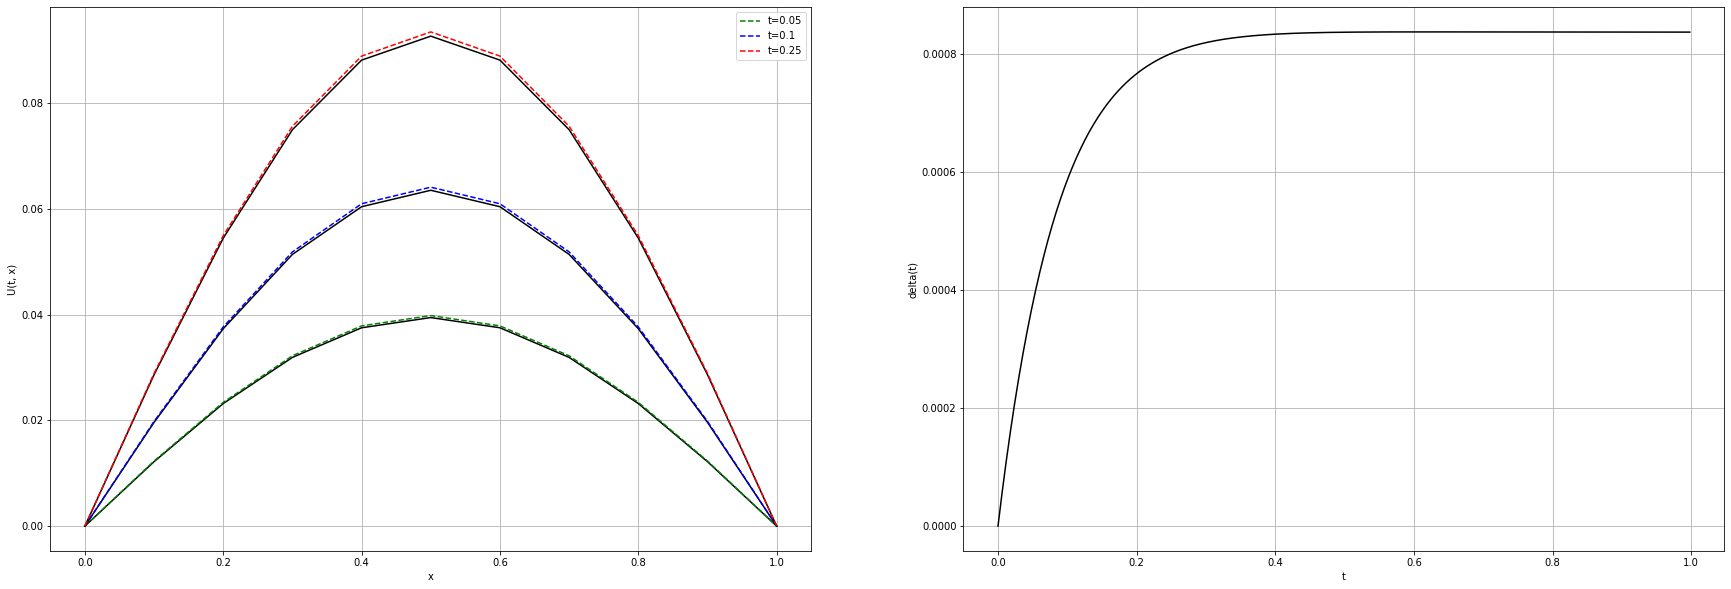

In [8]:
exp_grid = explicit_scheme()
exp_errors = find_errors(exp_grid)
view_mode(exp_grid, exp_errors)

---
### Неявная схема

In [9]:
def implicit_scheme():
    aj = sigma
    bj = -(1 + 2 * sigma)
    cj = sigma
    grid = np.zeros((K + 1, N + 1))
    
    for j in range(N + 1):
        grid[0][j] = u_x_0(j * h)
        
    for i in range(1, K):
        grid[i][0] = u_0_t(i * tau)
        grid[i][N] = u_l_t(i * tau)
        
    for i in range(1, K + 1):
        M = np.zeros((N - 1, N - 1))
        d = np.zeros(N - 1)
        
        M[0][0] = bj
        M[0][1] = cj
        d[0] = -grid[i - 1][1] - tau*g(X[1]) - sigma * u_0_t(i * tau)
        
        for j in range(1, N - 2):
            M[j][j - 1] = aj
            M[j][j] = bj
            M[j][j + 1] = cj
            d[j] = -grid[i - 1][j + 1] - tau*g(X[j + 1])
        
        M[N - 2][N - 3] = aj
        M[N - 2][N - 2] = bj
        d[N - 2] = -grid[i - 1][1] - tau*g(X[N - 2]) - sigma * u_l_t(i * tau)
        
        s = sweep_method(M, d)
        grid[i][1 : N] = s
        
    return grid

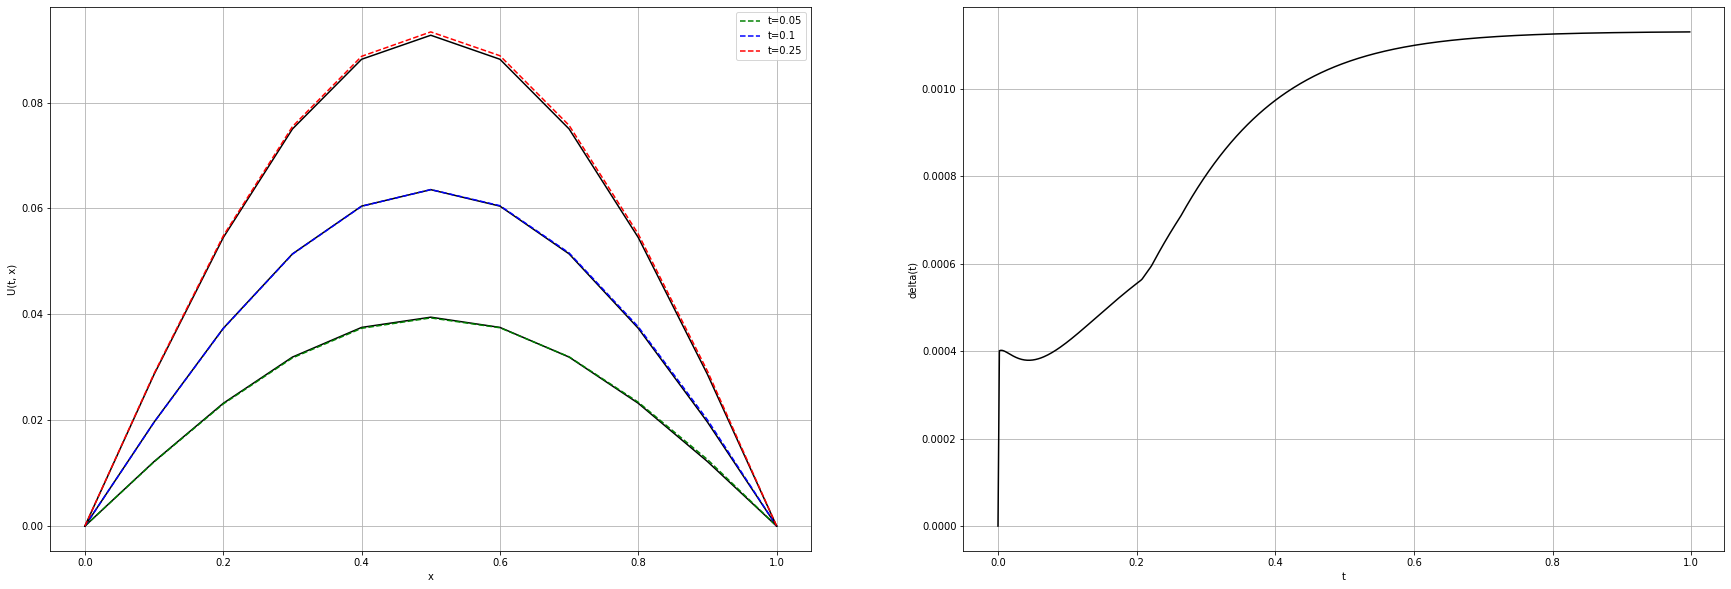

In [10]:
imp_grid = implicit_scheme()
imp_errors = find_errors(imp_grid)
view_mode(imp_grid, imp_errors)

---
### Схема Кранка-Николсона ($\theta = 0.5$)

In [11]:
def сrank_nikolson_scheme():
    aj = sigma * 0.5
    bj = -(1 + 2 * sigma * 0.5)
    cj = sigma * 0.5

    grid = np.zeros((K + 1, N + 1))
    
    for j in range(N + 1):
        grid[0][j] = u_x_0(j * h)

    for i in range(1, K):
        grid[i][0] = u_0_t(i * tau)
        grid[i][N] = u_l_t(i * tau)

    for i in range(1, K + 1):
        M = np.zeros((N - 1, N - 1))
        d = np.zeros(N - 1)

        M[0][0] = bj
        M[0][1] = cj
        d[0] = -(grid[i - 1][1] + tau * g(X[1]) + sigma * 0.5 * (grid[i - 1][2] - 2 * grid[i - 1][1] + grid[i - 1][0]) + sigma * 0.5 * u_0_t(i * tau))

        for j in range(1, N-2):
            M[j][j-1] = aj
            M[j][j] = bj
            M[j][j+1] = cj
            d[j] = -(grid[i - 1][j + 1] + tau * g(X[j + 1]) + sigma * 0.5 * (grid[i-1][j+2]-2 * grid[i - 1][j + 1] + grid[i - 1][j]))

        M[N-2][N-3] = aj
        M[N-2][N-2] = bj
        d[N-2] = -(grid[i - 1][N - 1] + tau * g(X[N - 2]) + sigma * 0.5 * (grid[i - 1][N] - 2 * grid[i - 1][N - 1]+grid[i - 1][N - 2]) + sigma * 0.5 * u_l_t(i * tau))

        s = sweep_method(M, d)
        grid[i][1 : N] = s

    return grid

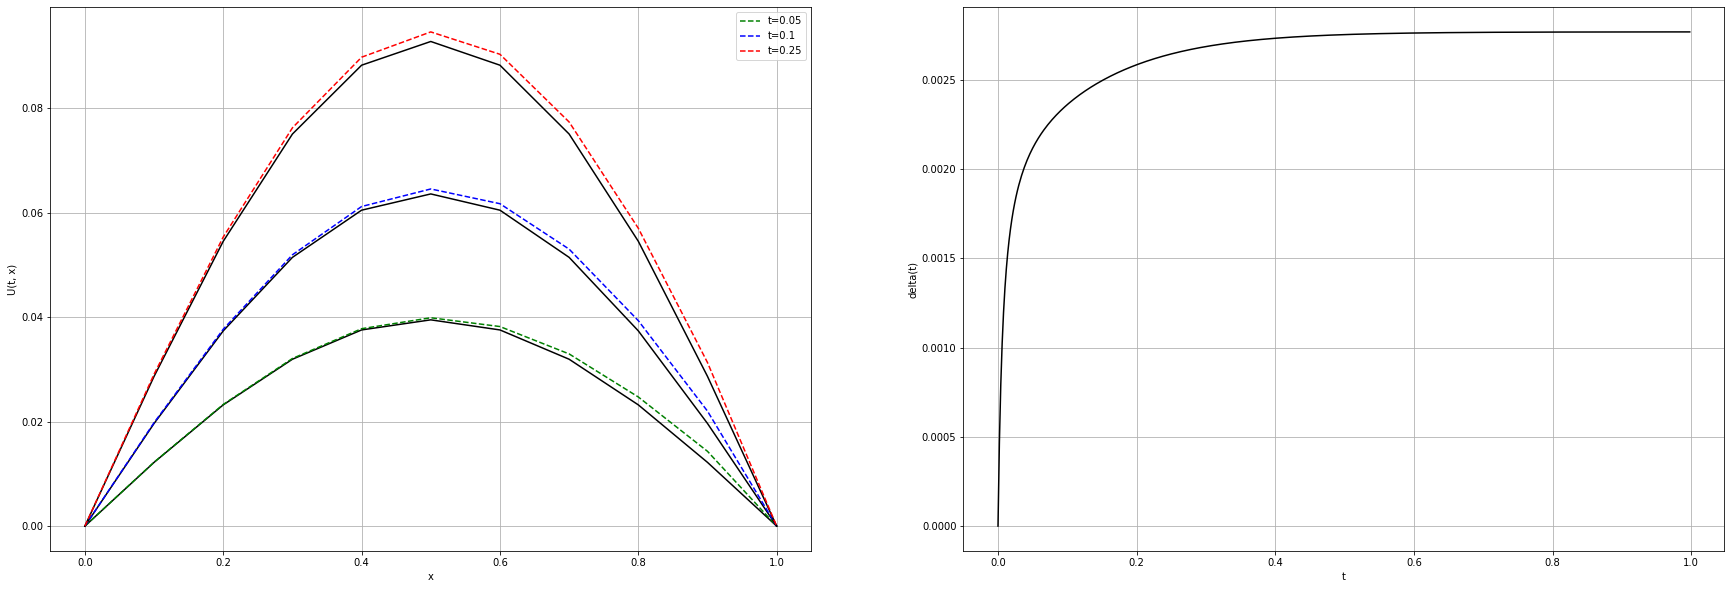

In [12]:
crank_grid = сrank_nikolson_scheme()
crank_errors = find_errors(crank_grid)
view_mode(crank_grid, crank_errors)